# Data description & Problem statement: 
The dataset is related to red vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests. For more details, please check: https://archive.ics.uci.edu/ml/datasets/wine+quality
* Dataset is imbalanced. The data has 4898 rows and 12 columns.
* This is a classification problem. The classification goal is to predict wine quality based on physicochemical tests.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train an ensemble of Deep Neural Network models by Keras/Tensorflow, and finally aggregate the results (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - AUC score:  0.95
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/wine quality/winequality-red.csv', sep=';') 

df['quality']=df['quality'].map({3:'L', 4:'L', 5:'L', 6:'L', 7:'H', 8:'H'})
df['quality']=df['quality'].map({'L':0,  'H':1})

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
X=df.drop('quality', axis=1)
y=df['quality']

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Removing outliers:
remove_outliers(X_train, y_train, ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
      'pH', 'sulphates', 'alcohol'], thresh=8)

number of outliers removed :   5


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=MinMaxScaler().fit(X)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [9]:
# we build a hold_out dataset for the final validation:

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#X_r, y_r = SMOTE(kind='svm').fit_sample(X_train, y_train)
X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
#X_r, y_r = X_train, y_train

from keras.utils import to_categorical
y_r=to_categorical(y_r)
y_test=to_categorical(y_test)

In [10]:
# KNN with Cross-Validation:
from sklearn.metrics import roc_auc_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, average, Input, merge, concatenate
from keras.layers.merge import concatenate
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
from keras.layers.normalization import BatchNormalization

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

# a single input layer
inputs = Input(shape=(X_r.shape[1],))


# model
model = Dense(80, activation='relu',  activity_regularizer=l2(0.001), kernel_initializer='glorot_uniform')(inputs)
model = Dropout(0.3)(model)
model = Dense(100, activation='sigmoid',  activity_regularizer=l2(0.001), kernel_initializer='glorot_uniform')(model)
model = Dropout(0.3)(model)
model = Dense(20, activation='relu',  activity_regularizer=l2(0.001), kernel_initializer='glorot_uniform')(model)

# output layer
outs = Dense(2, activation='softmax', activity_regularizer=l2(0.005))(model)

#generate a model from the layers above
model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer='adam',  loss='categorical_crossentropy')


monitor=EarlyStopping(monitor='val_loss', min_delta=0.001, patience=200, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
history=model.fit(X_r,y_r, epochs=500, batch_size=16, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer], verbose=0)
model.load_weights('best_weights.hdf5')

# Measure this fold's accuracy
auc_test=roc_auc_score(y_test, model.predict(X_test))
auc_train=roc_auc_score(to_categorical(y_train), model.predict(X_train))

print('Training auc score: ', auc_train, "\n")
print('Validation auc score: ', auc_test)

Epoch 00415: early stopping
Training auc score:  0.9485022495856026 

Validation auc score:  0.8952748627045837


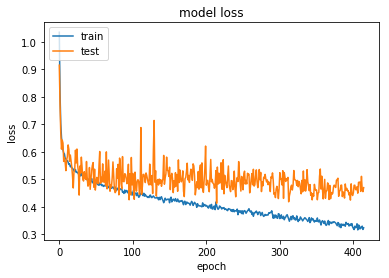

In [11]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[293  54]
 [ 13  40]]
Normalized confusion matrix
[[0.84 0.16]
 [0.25 0.75]]


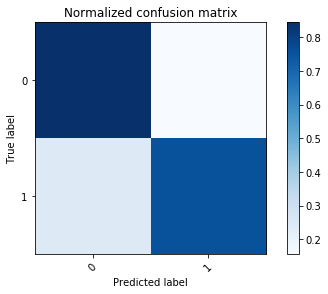

In [12]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [13]:
# Classification report:
report=classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print(report)

             precision    recall  f1-score   support

          0       0.96      0.84      0.90       347
          1       0.43      0.75      0.54        53

avg / total       0.89      0.83      0.85       400



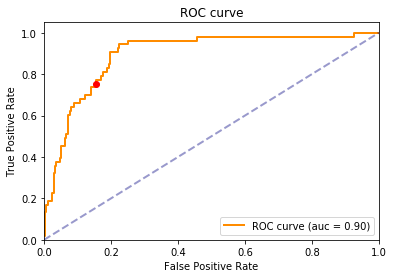

In [14]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[:, 1]), model.predict(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), model.predict(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

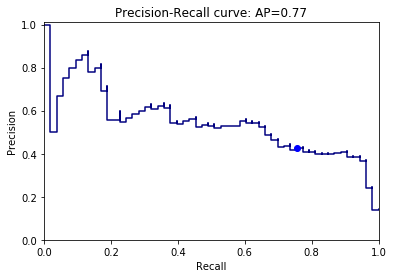

In [15]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test[:, 1], model.predict(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test, model.predict(X_test))

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1.01])
plt.xlim([0, 1.001])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()